In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
%matplotlib widget
import matplotlib.pyplot as plt

3d圖形範例 程式
確定有看到圖形之後就可以


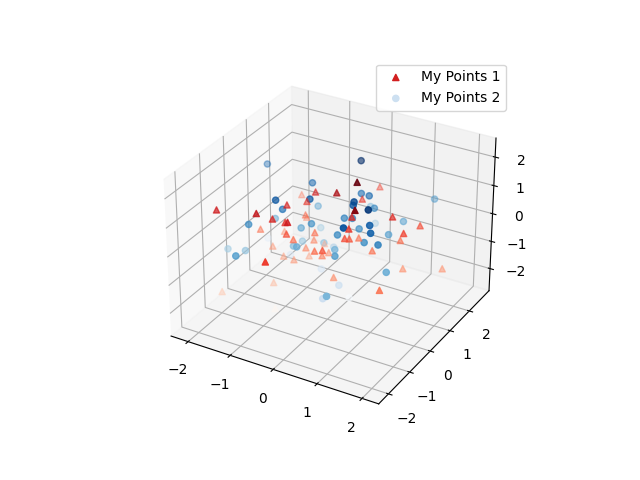

In [2]:
# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 產生 3D 座標資料
z1 = np.random.randn(50)
x1 = np.random.randn(50)
y1 = np.random.randn(50)
z2 = np.random.randn(50)
x2 = np.random.randn(50)
y2 = np.random.randn(50)

# 繪製 3D 座標點
ax.scatter(x1, y1, z1, c=z1, cmap='Reds', marker='^', label='My Points 1')
ax.scatter(x2, y2, z2, c=z2, cmap='Blues', marker='o', label='My Points 2')

# 顯示圖例
ax.legend()

# 顯示圖形
plt.show()

In [3]:
#ICP Library functions code
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''
    #tolerance = 0.001
    #max_iterations=20
    #init_pose = None
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [4]:

A = np.random.randint(0,5,(10,3))    # 20 points for test

rotz = lambda theta: np.array([[np.cos(theta),-np.sin(theta),0],
                                    [np.sin(theta),np.cos(theta),0],
                                    [0,0,1]])
trans = np.array([2.12,-0.2,1.3])
B = A.dot(rotz(np.pi/4).T) + trans
#print(B)
T, distances,i = icp(A, B)

np.set_printoptions(precision=3,suppress=True)
print(T)

[[ 0.707 -0.707  0.     2.12 ]
 [ 0.707  0.707  0.    -0.2  ]
 [ 0.     0.     1.     1.3  ]
 [ 0.     0.     0.     1.   ]]


In [5]:
A_X= [i[0] for i in A]
#B_X =np.array([i[0] for i in B]).T
B_X =[i[0] for i in B]
A_Y = [i[1] for i in A]
#B_Y = np.array([i[1] for i in B]).T
B_Y = [i[1] for i in B]
A_Z = [i[2] for i in A]
#B_Z = np.array([i[2] for i in B]).T
B_Z = [i[2] for i in B]
#B_Y = np.array(B_Y)
#B_Y = B_Y.T
B_Y

[1.9213203435596429,
 1.2142135623730952,
 1.2142135623730952,
 2.62842712474619,
 1.9213203435596429,
 4.0426406871192855,
 2.62842712474619,
 2.62842712474619,
 1.2142135623730952,
 -0.2]

In [6]:
A

array([[0, 3, 3],
       [1, 1, 4],
       [2, 0, 1],
       [0, 4, 2],
       [2, 1, 0],
       [2, 4, 3],
       [2, 2, 1],
       [0, 4, 3],
       [2, 0, 1],
       [0, 0, 3]])

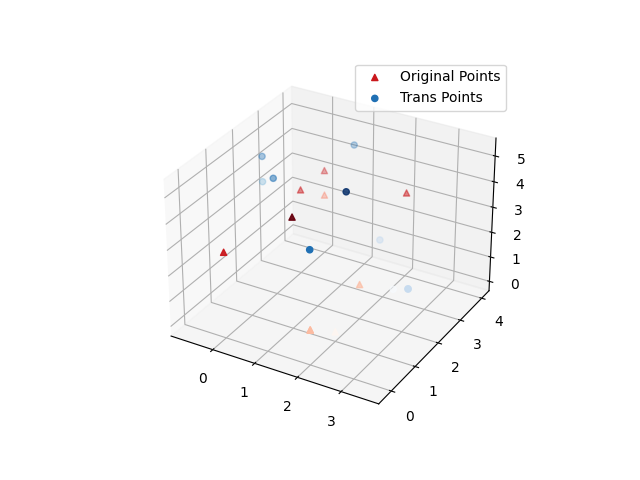

In [7]:
# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 繪製 3D 座標點
ax.scatter(A_X, A_Y, A_Z, c=A_Z, cmap='Reds', marker='^', label='Original Points')
ax.scatter(B_X, B_Y, B_Z, c=B_Z, cmap='Blues', marker='o', label='Trans Points')

# 顯示圖例
ax.legend()

# 顯示圖形
plt.show()

In [8]:
T

array([[ 0.707, -0.707,  0.   ,  2.12 ],
       [ 0.707,  0.707,  0.   , -0.2  ],
       [ 0.   ,  0.   ,  1.   ,  1.3  ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

Text(0.5, 0.92, 'Example of a uniformly sampled sphere')

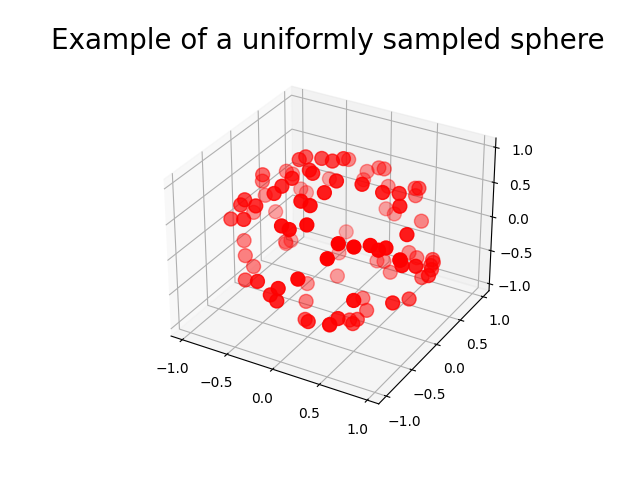

In [9]:
x = []
y = []
z = []
for i in range(100):
    u = np.random.normal(0,1)
    v = np.random.normal(0,1)
    w = np.random.normal(0,1)
    norm = (u*u + v*v + w*w)**(0.5)
    xi,yi,zi = u/norm,v/norm,w/norm
    x.append(xi)
    y.append(yi)
    z.append(zi)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
#ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(x, y, z, s=100, c='r', zorder=10)
ax.set_title('Example of a uniformly sampled sphere', fontdict={'fontsize':20})

In [13]:
A = []
for a,b,c in zip(x,y,z):
    A.append([a,b,c])

A = np.array(A)

B = A.dot(rotz(np.pi/4).T) #+ trans

In [14]:
A_X= [i[0] for i in A]
#B_X =np.array([i[0] for i in B]).T
B_X =[i[0] for i in B]
A_Y = [i[1] for i in A]
#B_Y = np.array([i[1] for i in B]).T
B_Y = [i[1] for i in B]
A_Z = [i[2] for i in A]
#B_Z = np.array([i[2] for i in B]).T
B_Z = [i[2] for i in B]
#B_Y = np.array(B_Y)
#B_Y = B_Y.T
B_Y

[0.856718197027874,
 -0.6199117385302565,
 0.7352385375628745,
 -0.22202011070493438,
 0.34110399376862044,
 0.027945092317118052,
 -0.20897798116508784,
 -0.4283200868784796,
 0.3624006218196653,
 0.15027804772413628,
 0.03895530529510263,
 0.2962252253671643,
 -0.5906804944574083,
 -0.5364436446561492,
 -0.5600328677418502,
 0.496193539449757,
 -0.17705454058190298,
 0.18960022802418286,
 -0.2971639352849564,
 -0.8634435901996327,
 0.2295489368212604,
 0.8625705867611496,
 -0.5665095808418394,
 0.5974116680817928,
 -0.23773218341249364,
 -0.6905244099896436,
 -0.23041877687537263,
 -0.18213244224147684,
 0.10851154128940495,
 0.49492119718142874,
 -0.27874755090416814,
 0.8018639311586949,
 0.5364574079705487,
 0.5498357332030778,
 0.9189512328135987,
 -0.24827688869960055,
 -0.49981398625041584,
 -0.45022066054435694,
 0.17865037425322214,
 0.2630474596218455,
 0.6224286697423338,
 -0.4137061518992174,
 -0.005870338499514118,
 -0.8478282957963738,
 -0.9207262995149407,
 0.3815590329

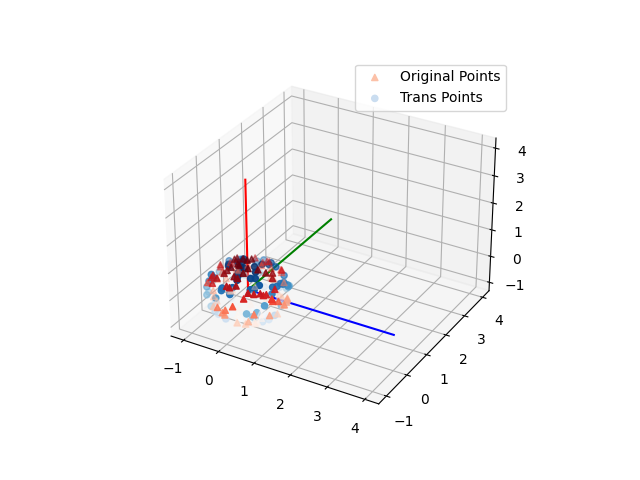

In [15]:
# 建立 3D 圖形
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 繪製 3D 座標點
ax.scatter(A_X, A_Y, A_Z, c=A_Z, cmap='Reds', marker='^', label='Original Points')
ax.scatter(B_X, B_Y, B_Z, c=B_Z, cmap='Blues', marker='o', label='Trans Points')

# 顯示圖例
ax.legend()

# 顯示圖形
# some settings
vleng = 4
aleng = vleng/3.
p = np.array([vleng, 0, 0])
q = np.array([0, vleng, 0])
r = np.array([0, 0, vleng])
ax.plot(*np.vstack([[0,0,0], p]).T, color='b')
ax.plot(*np.vstack([[0,0,0], q]).T, color='g')
ax.plot(*np.vstack([[0,0,0], r]).T, color='r')
plt.show()